# Jacob Prebys Exploratory Notebook 1

The data can be downloaded [here](https://grouplens.org/datasets/movielens/latest/)


In [4]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np
import datetime, random
from collections import Counter
from scipy import sparse


In [13]:
links = pd.read_csv('../../../data/big_data/ml-latest/links.csv')
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


This data matches these movie ids with those from IMDB and The Movie Database

[here](https://www.imdb.com/interfaces/) are the available datasets that imdb offers, we may want to use them to get additional info

In [59]:
movies = pd.read_csv('../../../data/big_data/ml-latest/movies.csv')
movies['genre_count'] = movies.genres.apply(lambda x: len(x.split('|')))
movies.head()

,movieId,title,genres,genre_count
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
1,2,Jumanji (1995),Adventure|Children|Fantasy,3
2,3,Grumpier Old Men (1995),Comedy|Romance,2
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3
4,5,Father of the Bride Part II (1995),Comedy,1


In [5]:
ratings = pd.read_csv('../../../data/big_data/ml-latest/ratings.csv')
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings.head(10)

,userId,movieId,rating,timestamp
0,1,307,3.5,2009-10-27 21:00:21
1,1,481,3.5,2009-10-27 21:04:16
2,1,1091,1.5,2009-10-27 21:04:31
3,1,1257,4.5,2009-10-27 21:04:20
4,1,1449,4.5,2009-10-27 21:01:04
5,1,1590,2.5,2009-10-27 21:00:36
6,1,1591,1.5,2009-10-27 21:04:35
7,1,2134,4.5,2009-10-27 21:04:24
8,1,2478,4.0,2009-10-27 21:00:39
9,1,2840,3.0,2009-10-27 21:05:00


In [50]:
tags = pd.read_csv('../../../data/big_data/ml-latest/tags.csv')
tags['timestamp'] = pd.to_datetime(tags['timestamp'], unit='s')
tags.head()

,userId,movieId,tag,timestamp
0,14,110,epic,2015-09-25 02:35:38
1,14,110,Medieval,2015-09-25 02:35:32
2,14,260,sci-fi,2015-09-13 18:36:50
3,14,260,space action,2015-09-13 18:37:01
4,14,318,imdb top 250,2015-09-18 22:26:35


Going to explore the ratings a little bit

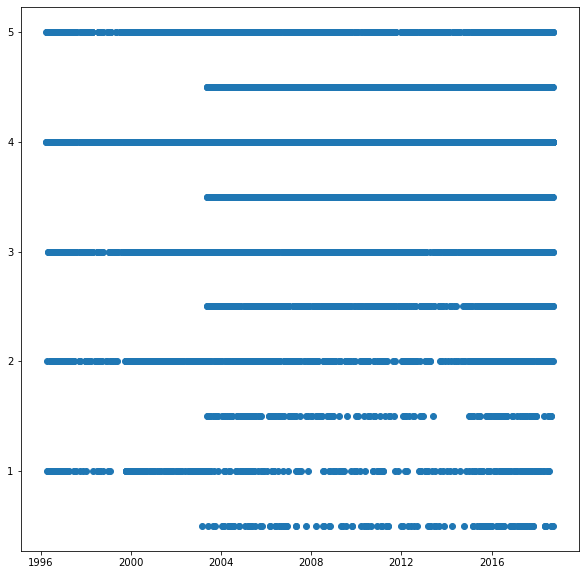

In [106]:
fig, ax = plt.subplots(figsize=(10,10))
index =  np.random.choice(ratings.index, 10000)
ax.scatter(ratings.timestamp[index], ratings.rating[index])

In [107]:
ratings[ratings.rating % 1 == 0.5].timestamp.describe()

count                 8035071
unique                7685378
top       2017-01-26 17:09:55
freq                      141
first     2003-02-18 21:34:27
last      2018-09-26 06:58:30
Name: timestamp, dtype: object

So apparently this review set only started accepting review scores ending with .5 in 2003

In [73]:
temp = []
for group in movies.genres:
    temp.extend(group.split('|'))
dict(Counter(temp))

{'Adventure': 4067,
 'Animation': 2663,
 'Children': 2749,
 'Comedy': 15956,
 'Fantasy': 2637,
 'Romance': 7412,
 'Drama': 24144,
 'Action': 7130,
 'Crime': 5105,
 'Thriller': 8216,
 'Horror': 5555,
 'Mystery': 2773,
 'Sci-Fi': 3444,
 'IMAX': 197,
 'Documentary': 5118,
 'War': 1820,
 'Musical': 1113,
 'Western': 1378,
 'Film-Noir': 364,
 '(no genres listed)': 4266}

We've got a ton of films labeled comedy, but we also have a lot of films with no genre at all, let's see those.

In [77]:
no_genre = movies[movies['genres'] == '(no genres listed)']
no_genre.sample(15)

,movieId,title,genres,genre_count
37449,146972,Forbidden (1954),(no genres listed),1
33022,136606,Le chant du Styrène (1958),(no genres listed),1
35944,143434,The Italian Key (2011),(no genres listed),1
38655,149929,Olvidados (2014),(no genres listed),1
45172,164975,After the Promise (1987),(no genres listed),1
40049,153296,The Tribulations of Balthazar Kober (1988),(no genres listed),1
41759,157294,Hannibal Takes Edinburgh (2016),(no genres listed),1
56937,190855,Without the King (2007),(no genres listed),1
44843,164250,Bellini e o Demônio (2008),(no genres listed),1
50944,177443,Nat King Cole: Afraid of the Dark (2014),(no genres listed),1


It seems like the movies with no genre don't have a lot of information on them in general

In [79]:
ratings.shape

(27753444, 4)

In [83]:
ratings.userId.describe()

count    2.775344e+07
mean     1.419420e+05
std      8.170740e+04
min      1.000000e+00
25%      7.117600e+04
50%      1.420220e+05
75%      2.124590e+05
max      2.832280e+05
Name: userId, dtype: float64

In [84]:
def id_to_index(df):
    """
    maps the values to the lowest consecutive values
    :param df: pandas Dataframe with columns user, item, rating
    :return: pandas Dataframe with the extra columns index_item and index_user
    """

    index_item = np.arange(0, len(df.movieId.unique()))
    index_user = np.arange(0, len(df.userId.unique()))

    df_item_index = pd.DataFrame(df.movieId.unique(), columns=["movieId"])
    df_item_index["new_index"] = index_item
    df_user_index = pd.DataFrame(df.userId.unique(), columns=["userId"])
    df_user_index["new_index"] = index_user

    df["index_item"] = df["movieId"].map(df_item_index.set_index('movieId')["new_index"]).fillna(0)

    return df

In [85]:
id_to_index(ratings)

,userId,movieId,rating,timestamp,index_item,index_user
0,1,307,3.5,2009-10-27 21:00:21,0,0
1,1,481,3.5,2009-10-27 21:04:16,1,0
2,1,1091,1.5,2009-10-27 21:04:31,2,0
3,1,1257,4.5,2009-10-27 21:04:20,3,0
4,1,1449,4.5,2009-10-27 21:01:04,4,0
...,...,...,...,...,...,...
27753439,283228,8542,4.5,2013-09-22 20:46:35,9793,283227
27753440,283228,8712,4.5,2013-09-22 20:45:51,7826,283227
27753441,283228,34405,4.5,2013-09-22 20:48:09,1080,283227
27753442,283228,44761,4.5,2012-11-29 03:25:24,4306,283227


In [93]:
mat = sparse.coo_matrix((ratings['rating'], (ratings["userId"], ratings["movieId"])))

In [99]:
table = pd.DataFrame.sparse.from_spmatrix(mat)

In [100]:
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283229 entries, 0 to 283228
Columns: 193887 entries, 0 to 193886
dtypes: Sparse[float64, 0.0](193887)
memory usage: 317.6 MB


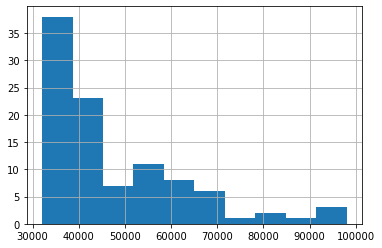

In [13]:
ratings.groupby('movieId')['rating'].count().sort_values()[-100:].hist(bins=10)